# Catalogue - Nico Keeghan

In [1]:
# Import various libraries 

import numpy as np
import astropy
import photutils
import ccdproc
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from photutils import DAOStarFinder
from photutils import detect_sources, deblend_sources, source_properties
from scipy.ndimage import shift
import gc                               

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

/tmp/ipykernel_649/1009457395.py:14: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/tmp/ipykernel_649/1009457395.py:14: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/tmp/ipykernel_649/1009457395.py:14: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg


We decided to find the positions of stars using the model fitting approach, since some of the stars are very close together, meaning that the segmentation method would not be able to distinguish between the stars.

All of our images have been shifted to the same reference point, so we can use the positions from one of the images to find the locations of the star in all of the images. Since the 60-second R band image contains the most stars (because cool red stars are more common than hot blue stars, and stars detectable in the B band will also be likely detectable in the R band), we will use the positions from the R-band.

In [2]:
band = 'R'
exptime = 60.0

filename = 'NGC_3293_%s_%i_median.fits' % (band, int(exptime))
scim = CCDData.read("./combined_ims/" + filename, unit = "adu")

# compute the median of the fits image to get the background, ignoring nan values
med=np.nanmedian(scim.data)

# subtract the background off the image
scim.data=scim.data-med

# compute the mean, median, and standard deviation of the image
mean, median, std = astropy.stats.sigma_clipped_stats(scim.data, sigma=3.0, maxiters=5)    
print('Image stats (mean, median and standard deviation):', mean,median,std)

# find stars using model fit
daofind=DAOStarFinder(fwhm=10.0, threshold = 12*std)
sources = daofind(scim.data)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Image stats (mean, median and standard deviation): -0.9639915 -1.9916203 33.002216


The mean and median are close to 0 which means that the background has been subtracted successfully. The mean and median counts are slightly negative due to noise.

We then plotted the positions of the located sources on the image to make sure that the detection worked properly.

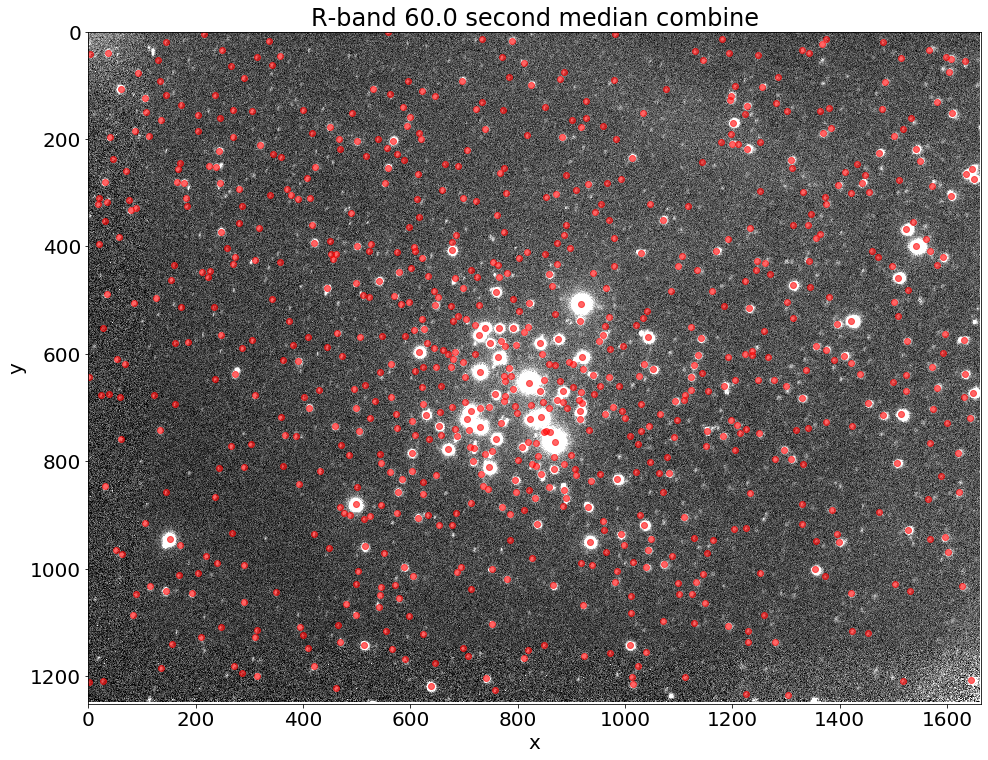

In [3]:
positions = [sources['xcentroid'],sources['ycentroid']]

plt.figure(figsize=(16,16))
plt.rcParams['font.size'] = 20

# plot the sources detected using the model fit
plt.imshow(scim.data, cmap='gray', vmin=-90, vmax=190)
plt.scatter(positions[0],positions[1],color='red',alpha=0.6)
plt.title('{band}-band {exptime} second median combine'.format(band=band,exptime=exptime))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,np.shape(scim)[1])
plt.ylim(np.shape(scim)[0],0)
plt.show()


***Figure 1.*** Median combined R-band science image of NGC 3293 with 60 second exposure time. Marked in red are the stars located using a 2D Gaussian model fit approach. This approach has identified all of the key stars in our cluster. 

We will now run aperture photometry over all of the bands on these positions. We will use a 10 pixel radius since we have several stars that are close together so that we don't capture too much light from nearby stars. If the maximum counts of a pixel within the aperture is greater than 50000 counts, we use the 5 second exposure image instead, as in this image the star will (hopefully) not be saturated.

We start by reading in all of the fits images.

In [4]:
BANDS = ['B','V','R']
EXPTIMES = [5.0,60.0]

filenames = {
    band : {str(exptime) : 'NGC_3293_%s_%i_median.fits' % (band, int(exptime)) for exptime in EXPTIMES}
    for band in BANDS
}

# read in the fits images
scims = {
    band : {str(exptime) :
CCDData.read("./combined_ims/" + filenames[band][str(exptime)], unit = "adu")
    for exptime in EXPTIMES}
    for band in BANDS
}


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


Now we create the apertures using these positions, and then iterate through each band. We also add a column to the photometry table of each band called `exptime`. This contains the exposure time, in seconds, used for the star at this position.

In [5]:
# get positions into good format for CircularAperture
aperture_positions=[]
for x,y in zip(positions[0],positions[1]):
    aperture_positions.append((x, y))
    
# create circular apertures of radius 10 pixels
apertures = CircularAperture(aperture_positions, r=10.0)

phot_tables = {}

# iterate through bands
for band in BANDS:
    # sum up counts
    phot_table = aperture_photometry(scims[band]['60.0'], apertures)
    
    # add column with exposure times, setting default to 60 seconds
    phot_table.add_column(60.0,name='exptime')
    
    # get most extreme x and y values
    max_idx_y, max_idx_x = np.shape(scims[band]['60.0'].data)
    
    # look through positions to find saturated stars
    for row in phot_table:
        # get object position
        x = row['xcenter'].value
        y = row['ycenter'].value
        
        # define a square of maximum side length 14 fully within image, centred on star position
        # this square is contained within the circular aperture of radius 10 pixels
        region = scims[band]['60.0'].data[max(0,int(y)-7):min(int(y)+7,max_idx_y),max(0,int(x)-7):min(int(x)+7,max_idx_x)]

        # check to see if the star in this region has high counts
        if np.max(region) >= 50000:
            # use the 5 second image if saturated
            aperture = CircularAperture((x,y), r=10.0)
            this_phot_table = aperture_photometry(scims[band]['5.0'], aperture)
            
            # update photometry table with counts from 5 second exposure image
            row['aperture_sum'] = this_phot_table['aperture_sum']
            row['aperture_sum_err'] = this_phot_table['aperture_sum_err']
            row['exptime'] = 5.0

    # print example photometry
    print('Band:', band)
    print('Number of stars:', len(phot_table))
    print('Number of times 5 second exposure used:', len(phot_table[phot_table['exptime'] == 5.0]))
    print('First 10 entries:')
    print(phot_table[0:10])
    
    phot_tables[band] = phot_table

Band: B
Number of stars: 813
Number of times 5 second exposure used: 6
First 10 entries:
 id      xcenter            ycenter           aperture_sum     aperture_sum_err  exptime
           pix                pix                 adu                adu                
--- ------------------ ------------------ ------------------- ------------------ -------
  1  558.5821422495022  1.553447827399145   3676.440641173814 208.87779408797658    60.0
  2  215.4588279399274  3.983022591080132  3272.1503733232275 234.98370029956203    60.0
  3  981.2018783118364  5.161590232085893 -1654.6409835477475 227.44840364965995    60.0
  4 1373.7256085823674 13.534586033156419  14443.776867327144  270.4313592382843    60.0
  5  733.2994363144586 13.335078874553421  3069.6698446464025  255.1143958721625    60.0
  6  1181.245040725141 13.348170003563451   3068.918759941078  264.9674100339096    60.0
  7 336.13127255653905 17.162987601026444  3957.8905234822696  262.8682000397019    60.0
  8  788.960506675991

As expected, the photometry tables for all bands contain the same number of stars, as we are using the same positions for every band. Only 6 stars were detected as saturated in the B band, while there were 20 in the V band and 21 in the R band. This agrees with what we see when looking at the images in ds9, since the 60 second B band image has less saturated stars than the other images, and the V and R bands have similar saturated stars.

We also see that star 3 and star 10 have negative counts in the B band. This is likely because these stars are not distinguishable from noise in the B band, meaning that the counts in the aperture are basically just noise. The negative counts flag these stars as non-detections.

Since the photometry tables look good, we will save them to file. We will use the `ecsv` format which is recommended by `astropy` for saving a `QTable`.

In [6]:
for band in BANDS:
    savename = '%s_band_aperture_sum.escv' % band
    phot_tables[band].write(savename, format='ascii.ecsv')

To make sure that the files have saved properly, we read them in and print some values to check that they match the ones above.

In [7]:
from astropy.table import QTable

for band in BANDS:
    fn = '%s_band_aperture_sum.escv' % band
    phot_table = QTable.read(fn, format='ascii.ecsv')
    print('Band:', band)
    print('Number of stars:', len(phot_table))
    print('Number of times 5 second exposure used:', len(phot_table[phot_table['exptime'] == 5.0]))
    print('First 10 entries:')
    print(phot_table[0:10])


Band: B
Number of stars: 813
Number of times 5 second exposure used: 6
First 10 entries:
 id      xcenter            ycenter           aperture_sum     aperture_sum_err  exptime
           pix                pix                 adu                adu                
--- ------------------ ------------------ ------------------- ------------------ -------
  1  558.5821422495022  1.553447827399145   3676.440641173814 208.87779408797658    60.0
  2  215.4588279399274  3.983022591080132  3272.1503733232275 234.98370029956203    60.0
  3  981.2018783118364  5.161590232085893 -1654.6409835477475 227.44840364965995    60.0
  4 1373.7256085823674 13.534586033156419  14443.776867327144  270.4313592382843    60.0
  5  733.2994363144586 13.335078874553421  3069.6698446464025  255.1143958721625    60.0
  6  1181.245040725141 13.348170003563451   3068.918759941078  264.9674100339096    60.0
  7 336.13127255653905 17.162987601026444  3957.8905234822696  262.8682000397019    60.0
  8  788.960506675991

These tables look good!